Run this initial code block

In [5]:
import pandas as pd
import boto3


boto3 setup:

In [6]:
s3 = boto3.resource('s3')

s3_obj = s3.Bucket("spotify-song-recommender-data").Object('light_spotify_dataset.csv').get()

song_data = pd.read_csv(s3_obj['Body'])

song_data.describe()
# song_data.head()


,variance,Release Date,Tempo,Loudness,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,Instrumentalness
count,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000,236988.000000
mean,0.658932,2008.472826,120.609685,-8.038657,40.003705,62.369166,59.127492,47.656966,11.748042,19.905333,26.156194,5.440052
std,0.320735,14.756158,28.966358,3.842215,18.770245,22.083376,17.069117,23.801800,12.443653,16.551294,29.047331,17.662526
min,-1.000000,1900.000000,33.000000,-46.770000,0.000000,0.000000,6.000000,0.000000,2.000000,1.000000,0.000000,0.000000
25%,0.833514,2002.000000,97.000000,-9.890000,27.000000,48.000000,48.000000,29.000000,4.000000,10.000000,2.000000,0.000000
50%,0.833514,2015.000000,120.000000,-7.190000,39.000000,64.000000,60.000000,47.000000,6.000000,13.000000,14.000000,0.000000
75%,0.833514,2019.000000,140.000000,-5.370000,52.000000,80.000000,72.000000,66.000000,16.000000,25.000000,44.000000,0.000000
max,1.000000,2024.000000,200.000000,3.740000,100.000000,100.000000,99.000000,99.000000,97.000000,100.000000,100.000000,100.000000


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [8]:
scaler = StandardScaler()

In [9]:
features = ['Tempo', 'Loudness', 'Energy', 'Danceability', 'Positiveness', 'Speechiness', 'Acousticness', 'Instrumentalness']
X = song_data[features]
X_scaled = scaler.fit_transform(X)

Identifying Optimal Number of Clusters (Elbow Plot)

In [17]:
def optimize_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)
    fig = plt.subplots(figsize=(10,5))
    plt.plot(means, inertias,'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Interia')
    plt.grid(True)
    plt.show()


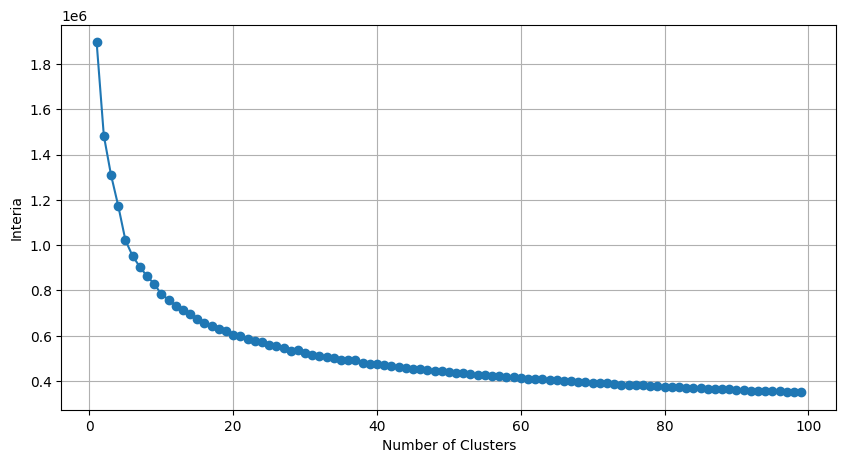

In [19]:
optimize_k_means(X_scaled, 100)

Applying K Means and MiniBatch Clustering

In [10]:
kmeans = KMeans(n_clusters=60, random_state=1)
mini_Batch_Kmeans = MiniBatchKMeans(n_clusters=60, random_state=1)

In [11]:
kmeans.fit(X_scaled)
mini_Batch_Kmeans.fit(X_scaled)

MiniBatchKMeans(n_clusters=60, random_state=1)

In [12]:
song_data['miniKmean_60'] = mini_Batch_Kmeans.labels_


In [12]:
song_data

,artist,song,emotion,variance,Genre,Release Date,Key,Tempo,Loudness,Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,Instrumentalness,miniKmean_60
0,ABBA,She's My Kind Of Girl,joy,0.447619,pop,2014,F Maj,128,-6.00,No,31,78,56,60,3,31,7,0,2
1,ABBA,"Andante, Andante",love,0.202222,pop,1980,A# Maj,102,-10.72,No,59,36,52,38,2,7,68,0,20
2,ABBA,As Good As New,sadness,0.300881,pop,1979,E Maj,139,-5.70,No,50,78,85,97,3,8,20,2,44
3,ABBA,Bang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,52,76,50,89,3,32,3,0,44
4,ABBA,Bang-A-Boomerang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,52,76,50,89,3,32,3,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236983,(Eri Sasaki),Gate Of Steiner,sadness,0.833514,"Unknown,Unknown,Unknown",2018,D min,148,-6.44,No,41,61,41,37,4,14,20,0,54
236984,(Elena Tsagrinou),El Diablo,love,0.833514,"Unknown,Unknown,Unknown",2021,A min,114,-7.78,No,51,66,66,62,13,84,0,0,30
236985,(Dima Bilan),Believe,joy,0.833514,"Unknown,Unknown,Unknown",2009,C min,134,-6.72,No,36,73,55,24,5,22,5,0,54
236986,(Ani Lorak),Shady Lady,joy,0.833514,"Unknown,Unknown,Unknown",2009,F# min,128,-13.00,No,37,70,71,77,5,7,5,0,40


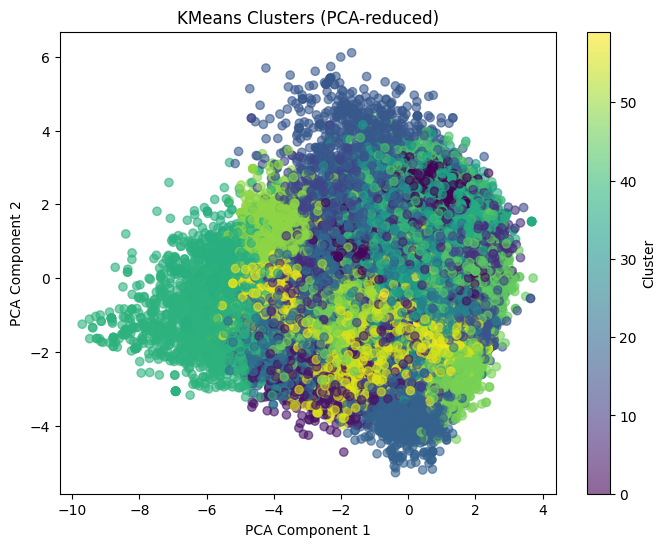

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=song_data['miniKmean_60'], cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clusters (PCA-reduced)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [13]:
# unique_genres = set()
# for genre_list in song_data['Genre']:
#     genres = [g.strip() for g in genre_list.split(',')]
#     unique_genres.update(genres)

# print(sorted(unique_genres))
print(song_data['Genre'].value_counts().head(35))

Genre
Unknown,Unknown,Unknown                       50019
pop                                           46883
rap                                           33204
alternative                                   19049
hip-hop                                       17317
rock                                          12956
folk                                          10620
metal                                         10491
soul                                           8741
electronic                                     5144
jazz                                           4302
progressive                                    3026
christian                                      2881
soundtrack                                     2576
reggae                                         1957
comedy                                         1031
world                                           308
xmas                                            300
Unknown                                         289
countr

In [14]:
unique_genres = set()

for genre_str in song_data['Genre']:
    genres = [g.strip() for g in genre_str.split(',')]
    unique_genres.update(genres)

print(sorted(unique_genres))

['-1001333387036', '-1001578764788', '-1001686404118', '-1001747063611', '-1001819731063', '-1001854528204', '-j013fh', '00s', '1', '10 of 10 stars', '10s', '116 bpm', '118 bpm', '12', '1208fh', '123', '123 drippy sappy', '13 reasons why', '1301fh', '17', '1920s', '1930', '1962', '1964', '1966', '1968', '1971', '1973', '1977', '1978', '1981', '1982', '1985', '1986', '1987', '1988', '1990s', '1991', '1992', '1993', '1998', '1Live Fiehe', '1M', '2 stars', '2000', '2000s', '2001', '2004', '2008', '2009', '2010', '2010s', '2010s country rock', '2010s funk blues', '2011', '2012', '2013', '2013 single', '2014', '2014 single', '2015', '2015 gif', '2015 single', '2016', '2016 Loved', '2016 single', '2017', '2017 single', '2018', '2018 single', '2019', '2020', '2020 single', '2020s', '2021', '2022', '2022 single', '20s', '20th Century Classical', '21st century in music', '291ooo', '294o00', '2k11 mix', '2step', '3', '3 stars', '30 Strand Grass', '30s', '4 Stars', '40s', '420', '5 times or less'

In [15]:
test_song = song_data.iloc[[4456]] # Best I Ever Had -Drake
print(test_song)


     artist             song emotion  variance Genre  Release Date     Key  \
4456  Drake  Best I Ever Had     joy  0.411265   rap          2024  C# Maj   

      Tempo  Loudness Explicit  Popularity  Energy  Danceability  \
4456    162     -2.18      Yes          80      92            40   

      Positiveness  Speechiness  Liveness  Acousticness  Instrumentalness  \
4456            56           38        13            19                 0   

      miniKmean_60  
4456            45  


In [16]:
test_song_cluster_id = test_song['miniKmean_60'].iloc[0]
cluster_list = song_data[song_data['miniKmean_60'] == test_song_cluster_id].copy()
print(len(cluster_list))
for songName in cluster_list['song']:
        print(f" - {songName}")

3126
 - Great To Be A Nerd
 - Particle Board
 - You Never Satisfy Me
 - Lonely
 - I Come Undone
 - Best I Ever Had
 - Big Boss Man
 - Buffalo Bill
 - Guitar Town
 - Another Time, Another Place
 - Gone For Good
 - Pain
 - Gotta Be Thug
 - Hands Up
 - Money Money Money Shouts
 - Phone Numbers
 - Rap City Freestyle (05.07.07)
 - Straight Spittin
 - The Get Back
 - Triple Threat
 - Victory Freestyle
 - Walk In New York
 - Think For Yourself
 - Run
 - Empire State Of Mind
 - Supercalifragilisticexpialidocious
 - Get Money, Spend Money, No Money
 - Ghetto Vet
 - The Predator
 - Still Not A Player
 - Set Me Free
 - Halls Of Illusions
 - If You Can't Beat 'Em Join 'Em
 - Like It Like That
 - The Good Son Part 1
 - Wet Dreamz
 - Heaven
 - Coyote
 - A Better Life
 - Barry Bonds
 - Prodigal Son
 - Melodies From Heaven
 - I Get Out
 - To Zion
 - Breakin' My Heart
 - Cash Money Millionaires
 - Fly In
 - Hot Boy
 - Hot Nigga
 - I Feel Good
 - Until It Breaks
 - What We Don't Know
 - Another Dollar
 

Computer Cosine similarity to the Cluster list

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
test_vector = test_song[features]
cluster_vectors = cluster_list[features]

similarities = cosine_similarity(test_vector, cluster_vectors)[0]
cluster_list['similarities'] = similarities

recommendations = cluster_list.sort_values(by='similarities', ascending=False)
print(recommendations[['artist', 'song', 'similarities', 'Genre', 'Popularity']].head(10))


                 artist             song  similarities  \
4456              Drake  Best I Ever Had      1.000000   
193036            Drake   Bitch Is Crazy      1.000000   
192810            Drake  Best I Ever Had      1.000000   
193084            Drake           Neatly      1.000000   
93296   Statik Selektah     The Imperial      0.999521   
88206         Tech N9ne          Seepage      0.999388   
189224           Eminem      Session One      0.999319   
97190            Skillz             2014      0.998934   
198968      Danny Brown      White Lines      0.998605   
193401      Doujah Raze         Find You      0.998483   

                          Genre  Popularity  
4456                        rap          80  
193036                  hip-hop          79  
192810                  hip-hop          79  
193084                  hip-hop          79  
93296                   hip-hop          21  
88206                   hip-hop          24  
189224                      rap        

Register Model using mlFlow

In [18]:
import mlflow
print(mlflow.__version__)

2.22.0


In [20]:
import mlflow.sklearn


mlflow.set_tracking_uri("http://ec2-3-14-247-214.us-east-2.compute.amazonaws.com:5000/")
with mlflow.start_run():
    mlflow.log_param('n_clusters', 60)
    mlflow.log_param('model_tyoe', 'miniBatchKMeans')

    mlflow.sklearn.log_model(mini_Batch_Kmeans, artifact_path='kmeans_model')




2025/05/23 23:21:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run luxuriant-bee-760 at: http://ec2-3-14-247-214.us-east-2.compute.amazonaws.com:5000/#/experiments/0/runs/151b679caf94401c8aba8c557138edbd
🧪 View experiment at: http://ec2-3-14-247-214.us-east-2.compute.amazonaws.com:5000/#/experiments/0


In [1]:
import awscli
print(awscli.__version__)

1.40.22
